In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import comb

N = 1000
rng = np.random.default_rng()

%matplotlib inline


# Finding $Pr[\text{SS remains at home}]$


In [46]:
def prob_remains_home(n):
    return comb(2 * n, n) * (0.5 ** n) * (0.5 ** n)

In [47]:
ns = np.arange(1, N + 1)
ps = prob_remains_home(ns)

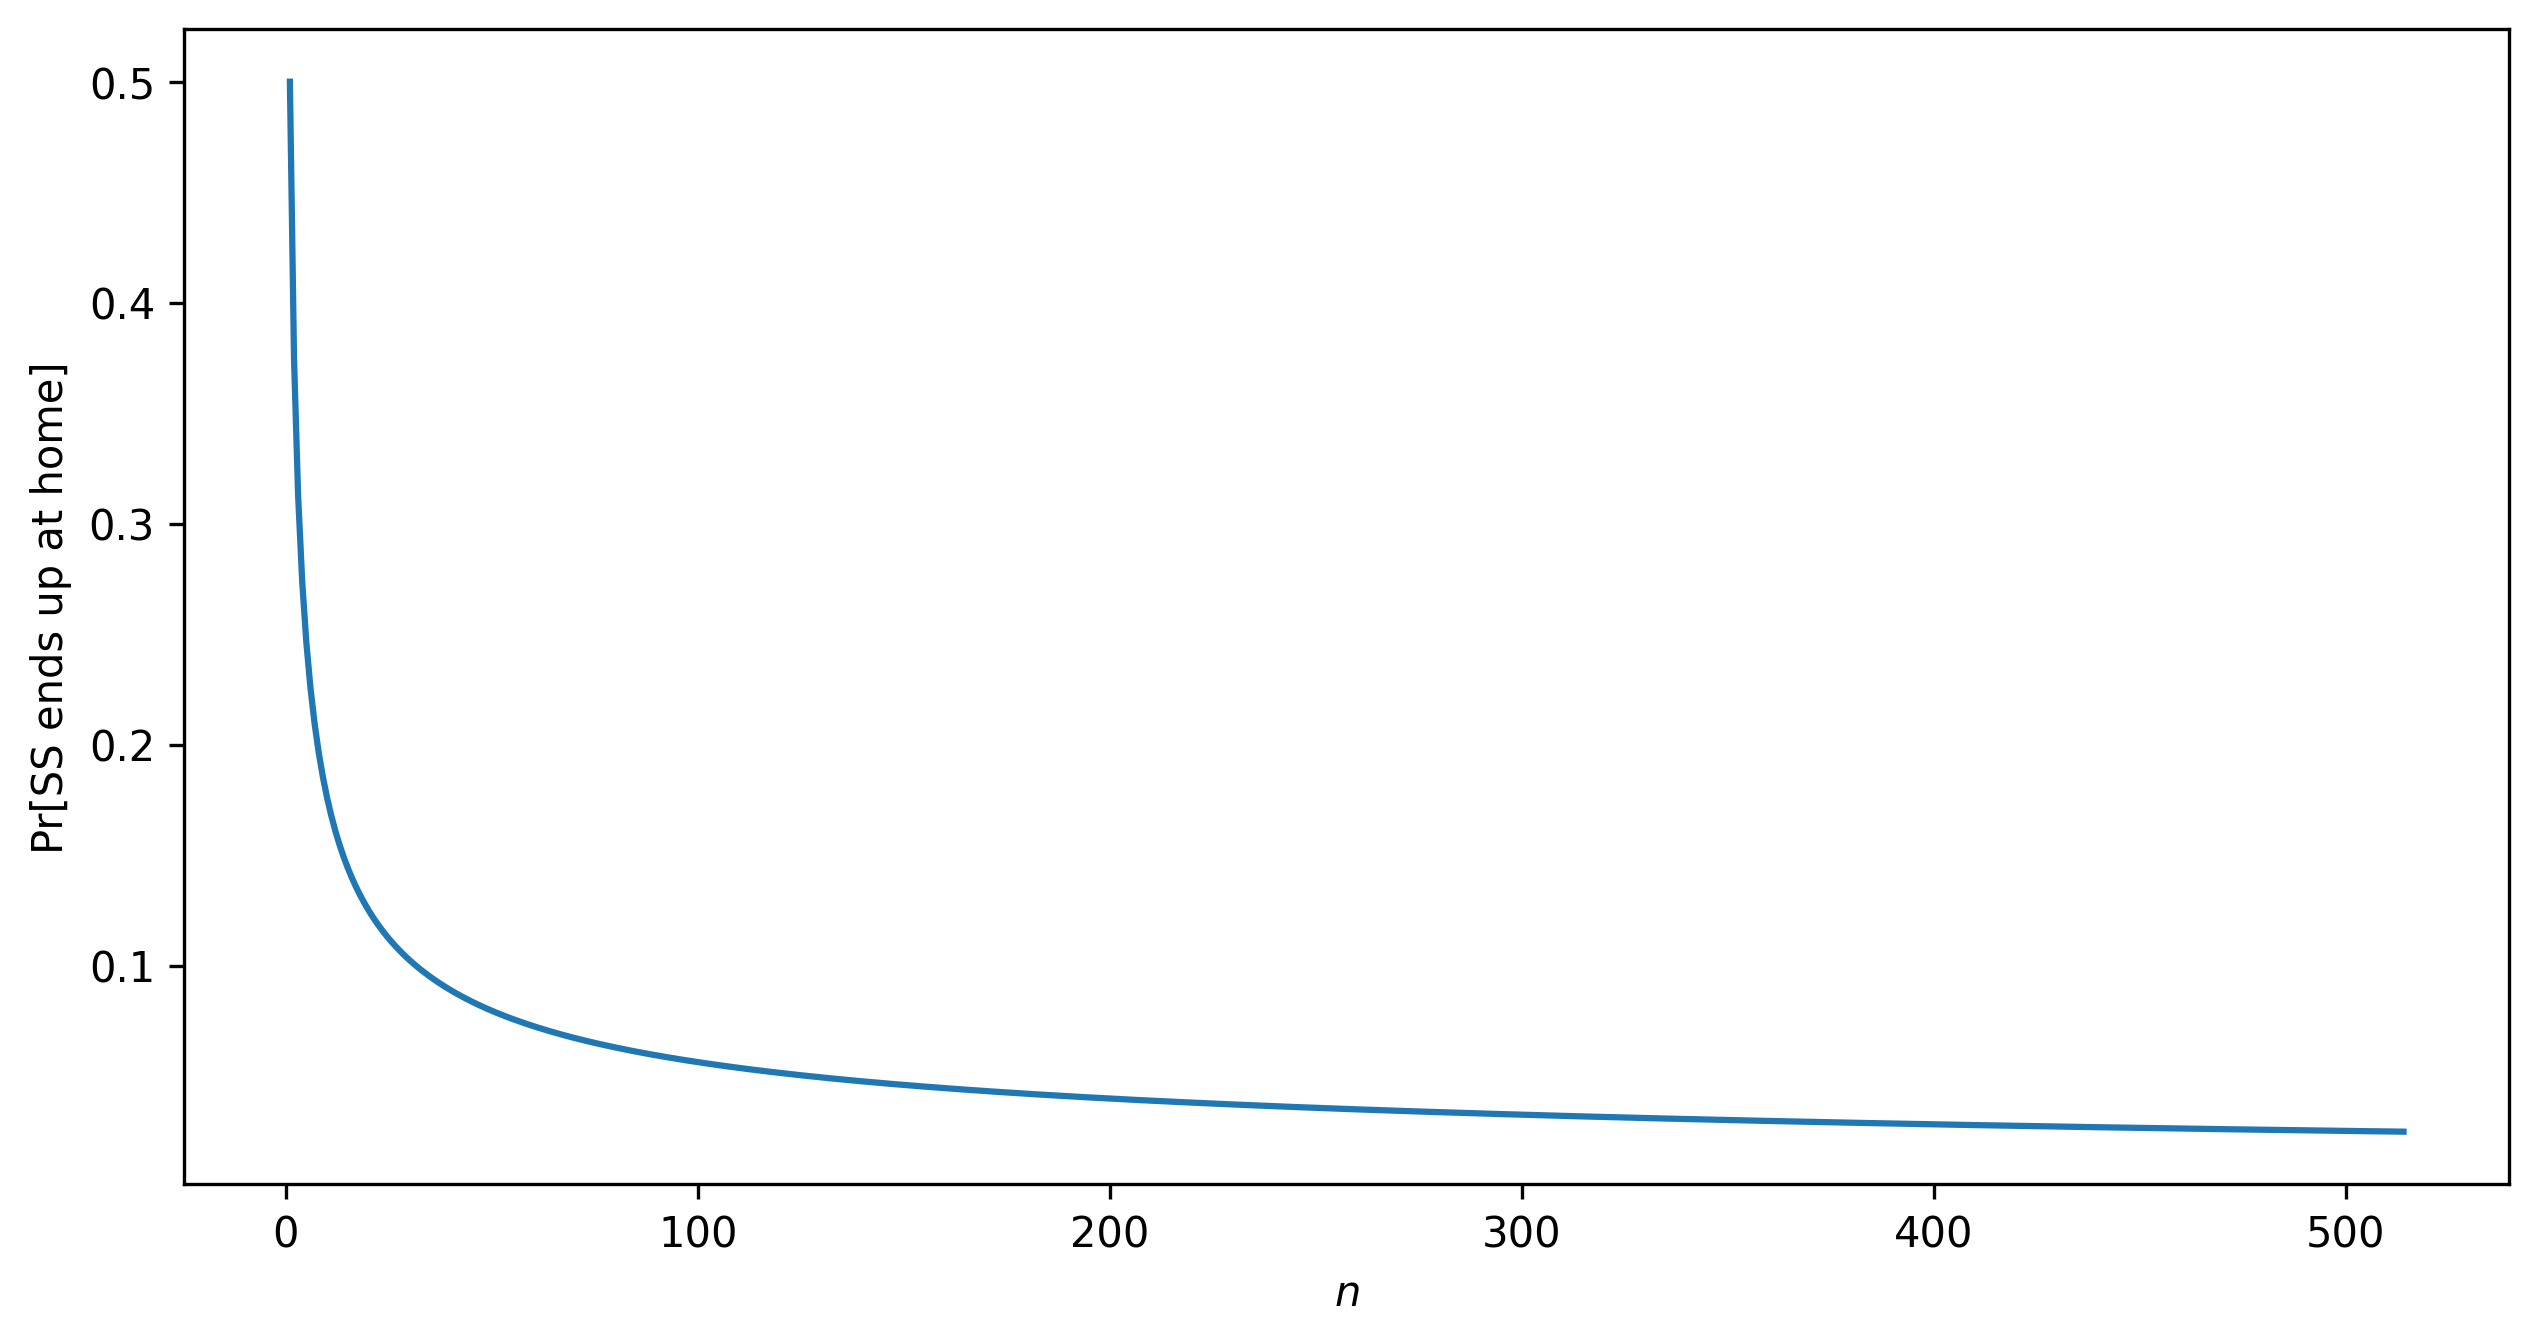

In [48]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

sns.lineplot(x=ns, y=ps, ax=ax)
ax.set_ylabel("Pr[SS ends up at home]")
ax.set_xlabel("$n$")

fig.savefig("graphics/02-endsathome", bbox_inches='tight')
plt.show(fig)

# Finding $\mathbb E[\text{SS comes home}]$

In [49]:
def simulate_rd_walk_once(n):
    directions = rng.choice([-1, 1], n, replace=True)
    locations = np.cumsum(directions)
    return locations.size - np.count_nonzero(locations)

def simulate_rd_walk(max_n):
    sim_results = []
    for n in range(1, max_n + 1):
        new_results = [{"n": n, "Home visits": simulate_rd_walk_once(n), "Iteration": i} for i in range(N)]
        sim_results = sim_results + new_results
    return pd.DataFrame(sim_results)

In [50]:
df_probs = simulate_rd_walk(N)
df_probs.sample(10)

,n,Home visits,Iteration
549389,550,3,389
522454,523,35,454
526521,527,20,521
922795,923,35,795
865141,866,26,141
739197,740,28,197
989939,990,7,939
170540,171,10,540
905680,906,56,680
901466,902,2,466


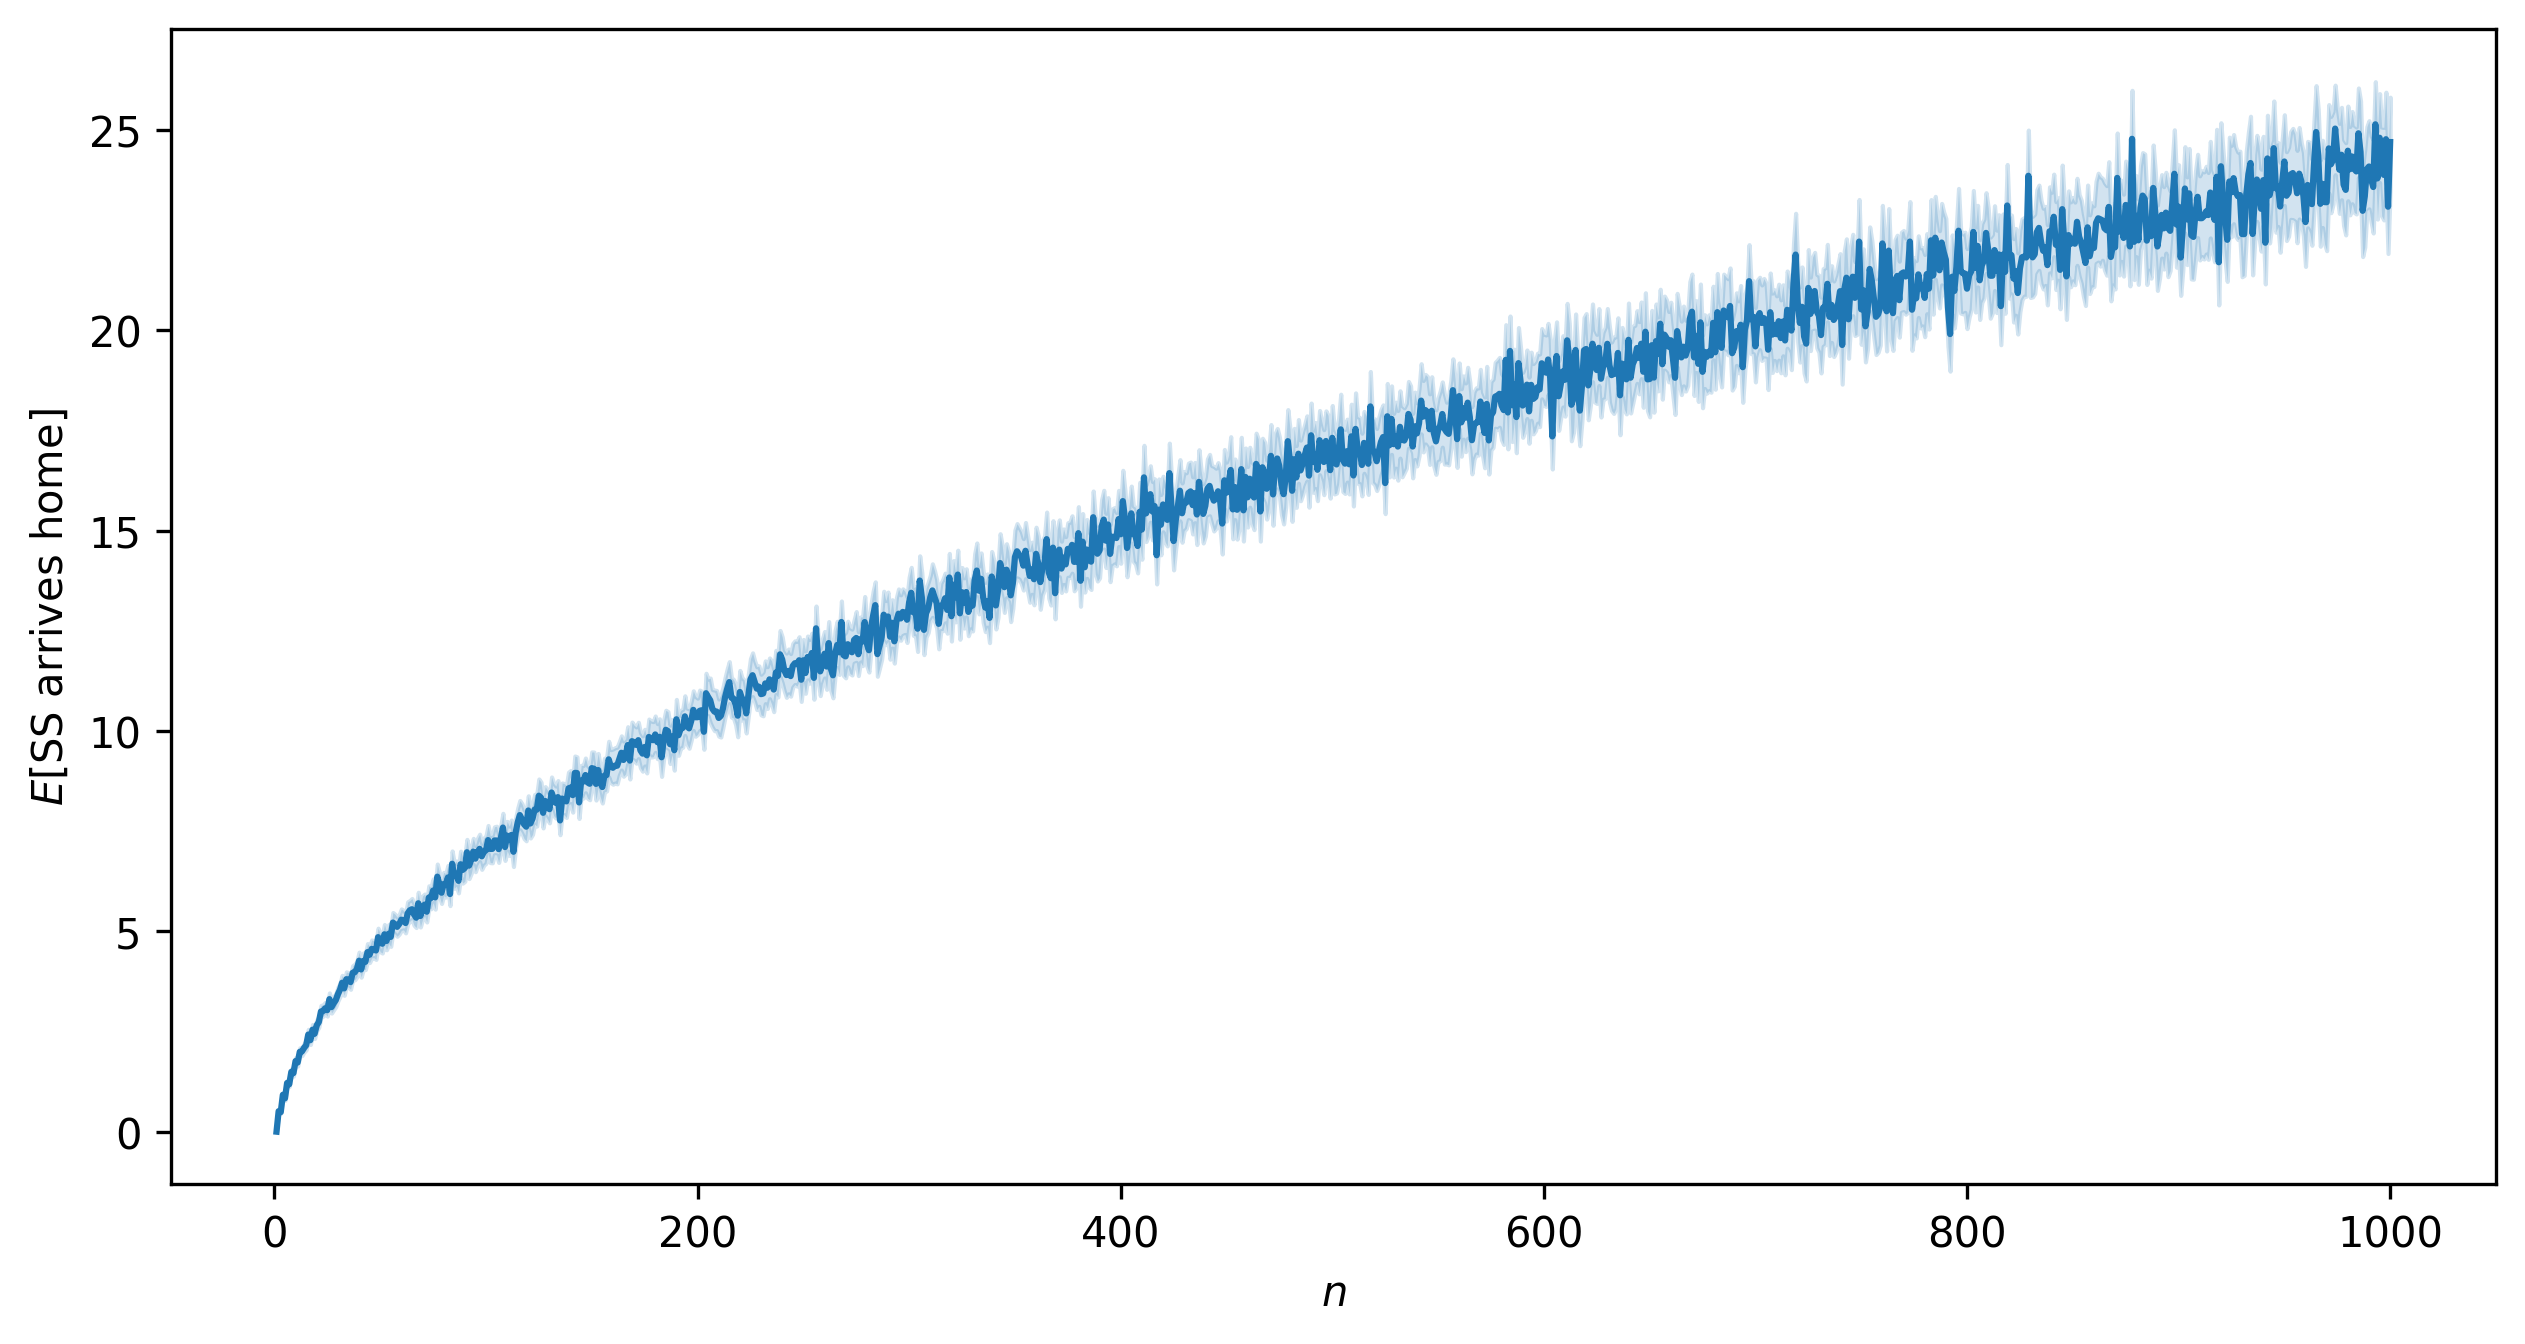

In [51]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

sns.lineplot(df_probs, x="n", y="Home visits")
ax.set_ylabel("$E$[SS arrives home]")
ax.set_xlabel("$n$")

fig.savefig("graphics/02-arriveshome", bbox_inches='tight')
plt.show(fig)